# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\U7W20E6\AppData\Local\Temp/ipykernel_24112/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

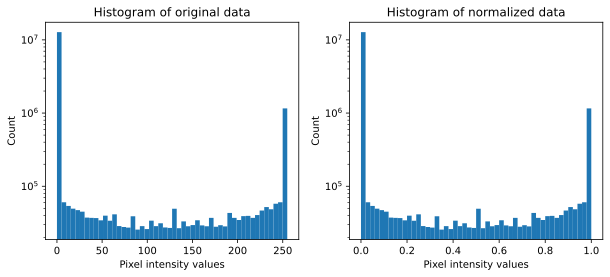

In [3]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

# Create train/test groups using DataLoader

In [4]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [5]:
# create a class for the model
def createTheMNISTNet(n_hidden, n_units):

  class mnistNet(nn.Module):
    def __init__(self, n_hidden, n_units):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,n_units)
      
      ### hidden layer
      self.n_hidden = n_hidden
      self.hidden_layers = nn.ModuleDict()
      for i in range(n_hidden):
        self.hidden_layers[f'layer{i}'] = nn.Linear(n_units, n_units)

      ### output layer
      self.output = nn.Linear(n_units, 10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      for i in range(self.n_hidden):
        x = F.relu( self.hidden_layers[f'layer{i}'](x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet(n_hidden, n_units)
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

createTheMNISTNet(2, 30)[0]

mnistNet(
  (input): Linear(in_features=784, out_features=30, bias=True)
  (hidden_layers): ModuleDict(
    (layer0): Linear(in_features=30, out_features=30, bias=True)
    (layer1): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=10, bias=True)
)

In [6]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(2, 50)

X,y = iter(train_loader).next()
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3072, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [14]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  hiddens = list(range(1, 4))
  units = list(range(50, 251, 50))

  train_acc = torch.zeros((len(units), len(hiddens)))
  test_acc = torch.zeros((len(units), len(hiddens)))

  for i, N_hidden in enumerate(hiddens):
    for j, N_units in enumerate(units):
      print(f'Model with {N_hidden} hidden layers with {N_units} units.')
      # create a new model
      net,lossfun,optimizer = createTheMNISTNet(N_hidden, N_units)

      # initialize losses
      losses    = torch.zeros(numepochs)
      trainAcc  = []
      testAcc   = []


      # loop over epochs
      for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

          # forward pass and loss
          yHat = net(X)
          loss = lossfun(yHat,y)

          # backprop
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # loss from this batch
          batchLoss.append(loss.item())

          # compute accuracy
          matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
          matchesNumeric = matches.float()             # convert to numbers (0/1)
          accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
          batchAcc.append( accuracyPct )               # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():
          yHat = net(X)
          
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    
      train_acc[j, i] = torch.tensor(np.mean(np.array(trainAcc[-10:])))
      test_acc[j, i] = torch.tensor(np.mean(np.array(testAcc[-10:])))
      # end epochs

  # function output
  return train_acc, test_acc


# Run the model and show the results!

In [15]:
trainAcc, testAcc = funtion2trainTheModel()

Model with 1 hidden layers with 50 units.
Model with 1 hidden layers with 100 units.
Model with 1 hidden layers with 150 units.
Model with 1 hidden layers with 200 units.
Model with 1 hidden layers with 250 units.
Model with 2 hidden layers with 50 units.
Model with 2 hidden layers with 100 units.
Model with 2 hidden layers with 150 units.
Model with 2 hidden layers with 200 units.
Model with 2 hidden layers with 250 units.
Model with 3 hidden layers with 50 units.
Model with 3 hidden layers with 100 units.
Model with 3 hidden layers with 150 units.
Model with 3 hidden layers with 200 units.
Model with 3 hidden layers with 250 units.


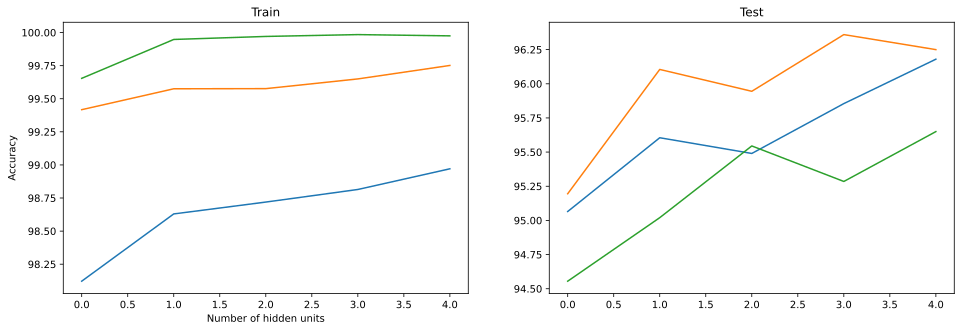

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainAcc)
ax[0].set_xlabel('Number of hidden units')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Train')
# ax[0].legend()

ax[1].plot(testAcc)
ax[0].set_xlabel('Number of hidden units')
ax[0].set_ylabel('Accuracy')
ax[1].set_title(f'Test')
# ax[1].legend()

plt.show()